<a href="https://colab.research.google.com/github/risksrobots/risk_profiling_MLresearch/blob/main/pet_project_RiskProfileClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт модулей


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import tree, ensemble
from matplotlib.colors import ListedColormap
from sklearn import linear_model, metrics
import sklearn.model_selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
import seaborn as sns
import pylab 
import scipy.stats as stats
from sklearn.preprocessing import PolynomialFeatures
import pickle
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
import lightgbm as lgb

In [ ]:
# GLOBALS

DATA_VERSION = '19.02.2022' # доступны версии: '31.03.2022', '19.02.2022' (для отображения корректных имен столбцов)
RESULTS = 'existed' # 'existed' - подгружаем последние существующие, 'new' - делаем новые
COLAB_PATH = '/content/drive/MyDrive/Проектное/Риски-роботы/'
PATH = ''

In [ ]:
# определяем среду

try:
    from google.colab import drive
    drive.mount('/content/drive')
    is_colab = True
except:
    is_colab = False 

if is_colab:
    PATH = COLAB_PATH


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Подгрузка данных

In [ ]:
# подгружаем результаты

if RESULTS == 'existed':
    if DATA_VERSION == '31.03.2022':
        with open(PATH + 'results_table_' + DATA_VERSION + '.pickle', 'rb') as fp:
            results = pickle.load(fp)
    elif DATA_VERSION == '19.02.2022':
        with open(PATH + 'results_table_' + DATA_VERSION + '.pickle', 'rb') as fp:
            results = pickle.load(fp)
else:
    results = pd.DataFrame(data=[], columns = ['hyperparams','MSE','Accuracy','precision','recall','f1-score'])

In [ ]:
results

,hyperparams,MSE,Accuracy,precision,recall,f1-score
KNN,"{'classifier__metric': 'manhattan', 'classifie...",0.2850,0.7570,0.7608,0.7570,0.7573
LogisticRegression,"{'C': 30, 'multi_class': 'auto', 'penalty': 'l...",0.2850,0.7570,0.7608,0.7570,0.7573
RandomForest,"{'classification__bootstrap': False, 'classifi...",0.2354,0.7877,0.7900,0.7877,0.7883
RandomForest_15feat,"{'classification__bootstrap': False, 'classifi...",0.1769,0.8318,0.8340,0.8318,0.8325
GradientBoosting(sklearn),"{'classifier__criterion': 'friedman_mse', 'cla...",0.1866,0.8236,0.8250,0.8236,0.8241
XGboost,"{'classifier__learning_rate': 0.1, 'classifier...",0.1594,0.8460,0.8476,0.8460,0.8466
XGboost(gamma tuning),"{'classifier__gamma': 0.8, 'classifier__learni...",0.1579,0.8475,0.8493,0.8475,0.8481
LightGBM,"{'learning_rate': 0.1, 'boosting_type': 'gbdt'...",0.1576,0.8490,0.8507,0.8490,0.8495


In [ ]:
# подгрузка датасета для решения задачи

df = pd.read_excel(PATH + '/dataset_'+ DATA_VERSION +'.xlsx', index_col=0)
df.head(10)

,"Среднедневное количество сделок инвестора в день за все дни, шт","Среднедневное количество сделок инвестора в торговые дни, шт","Количество инструментов в портфеле инвестора за все время конкурса, шт",Стандартное отклонение доходов инвестора,Value at Risk (VaR),"Просадка c продажами по стоимости портфеля инвестора (рассчитанная от начальной стоимости портфеля), доли","Просадка c продажами по стоимости портфеля инвестора (рассчитанная от максимальной стоимости портфеля), доли","Просадка по стоимости портфеля инвестора (рассчитанная от начальной стоимости портфеля), доли",Средняя просадка по прибыли,Доля дней с убытками,"Просадка по стоимости портфеля инвестора (рассчитанная от максимальной стоимости портфеля), доли",Средняя просадка по прибыли (от максимального значения),Доля дней ниже максимальной прибыли,итоговый доход,Размах вариации моментумов финансового результата,Риск-профиль оригинальный,Год
1_62009,0.125000,2.666667,2,1635.635011,-3917.212,NaN,-0.000220,-3.893488,-5031.165333,0.714286,-4.982029,-6296.288421,0.904762,-12653.68,21.278788,4,2015
1_62125,0.437500,1.473684,1,3377.419206,-14113.100,-0.017226,-0.054064,-17.259298,-3797.045455,0.611111,-1.876541,-9073.076923,0.361111,-7665.00,31.448554,4,2015
1_55070,1.250000,4.000000,8,744.988435,-3379.600,NaN,NaN,-0.038421,-7.300000,0.037037,-0.294324,-2548.320000,0.092593,5292.20,1.892929,3,2015
1_57920,0.562500,2.571429,3,2061.959591,-7093.500,NaN,-0.036528,-2.820647,-7728.571429,0.897436,-8.876011,-9408.571429,0.897436,-21910.00,6.320573,4,2015
1_57367,4.375000,6.222222,13,22210.756410,-92913.860,-0.043022,-0.050725,-22.299753,-176614.041667,0.979592,-22.299753,-176614.041667,0.979592,-316392.00,1.392604,5,2015
1_58298,0.296875,2.714286,3,1702.291831,-9034.810,NaN,NaN,-12.106771,-1452.812500,0.372093,-1.691423,-5415.937500,0.186047,37.00,13.650660,4,2015
1_53786,3.656250,7.800000,14,7436.825548,-18965.448,-0.027152,-0.014821,-10.961978,-31768.470400,0.909091,-3.722314,-38361.049412,0.927273,-16441.70,4.162887,5,2015
1_58473,6.046875,17.590909,3,16586.688112,-72272.580,-0.009669,-0.017141,-1.096816,-8092.421429,0.325581,-0.559294,-59466.612500,0.372093,28376.90,71.525051,5,2015
1_49000,0.140625,2.250000,2,705.081790,-1542.800,NaN,-0.032199,0.000000,0.000000,0.000000,-0.200116,-1315.562500,0.727273,4979.00,3.145344,3,2015
1_63950,2.265625,8.529412,4,4120.147094,-10986.750,NaN,-0.022209,-1115.877404,-44635.096154,0.962963,-1115.877404,-44635.096154,0.962963,-71942.00,10.085900,5,2015


In [ ]:
df.shape

(39681, 17)

# Разведочный анализ (EDA)

##1. Семантический анализ фич

Здесь фичи - это признаки для определения риск-профиля.

Соответственно риск-профиль - это предсказываемый признак.

Был рассчитан по стандартному отклонению портфеля, поэтому данный признак надо исключить из датасета

1.1. Названия признаков хорошо интерпретируемы, однако неудобны, поэтому переименовываем сразу

In [ ]:
if DATA_VERSION == "19.02.2022":
    names = {'mean_deals_contest':'Количество сделок инвестора в день за все конкурсные дни, шт',
            'mean_deals_trade_days' :'Количество сделок инвестора в день в торговые дни, шт',
            'port_size':'Общее количество инструментов в портфеле инвестора за все время конкурса, шт',
            'deal_on_port_median':'Медианное значение отношения размера (цена*кол-во актива) сделки к стоимости портфеля инвестора',
            'VaR':'Value at Risk (VaR) стоимости портфеля инвесторa',
            'port_std':'Стандартное отклонение портфеля',
            'mean_instr':'Количество инструментов, одновременно находящихся в портфеле инвестора, шт',
            'mean_drawdown_full_entr':'Просадка по стоимости портфеля инвестора (рассчитанная от начальной стоимости портфеля), доли',
            'mean_drawdown_full_max':'Просадка по стоимости портфеля инвестора (рассчитанная от максимальной стоимости портфеля), доли',
            'mean_drawdown_sell_entr':'Просадка c продажами по стоимости портфеля инвестора (рассчитанная от начальной стоимости портфеля), доли',
            'mean_drawdown_sell_max':'Просадка c продажами по стоимости портфеля инвестора (рассчитанная от максимальной стоимости портфеля), доли',
            'risk_profile':'Риск-профиль оригинальный',
            'labels':'Риск-профиль предсказанный',
            'year':'Год',
            'incomes':'Доходность',
            'momentum_price': 'Моментум',
            'mean_drawdown_full_entr_abs':'Просадка по стоимости портфеля инвестора (рассчитанная от начальной стоимости портфеля), абсолютная',
            'mean_drawdown_full_entr_cnt':'Просадка по стоимости портфеля инвестора (рассчитанная от начальной стоимости портфеля), количество',
            'mean_drawdown_full_max_abs':'Просадка по стоимости портфеля инвестора (рассчитанная от максимальной стоимости портфеля), абсолютная',
            'mean_drawdown_full_max_cnt':'Просадка по стоимости портфеля инвестора (рассчитанная от максимальной стоимости портфеля), количество',
            'mean_drawdown_full_entr_cnt_share':'Просадка по стоимости портфеля инвестора (рассчитанная от начальной стоимости портфеля), доля дней',
            'mean_drawdown_full_max_cnt_share':'Просадка по стоимости портфеля инвестора (рассчитанная от максимальной стоимости портфеля), доля дней',
            'fin_result':'итоговый доход'}

elif DATA_VERSION == "31.03.2022":
    names = {'mean_deals_contest':'Среднедневное количество сделок инвестора в день за все дни, шт',
            'mean_deals_trade_days' :'Среднедневное количество сделок инвестора в торговые дни, шт',
            'port_size':'Количество инструментов в портфеле инвестора за все время конкурса, шт',
            'deal_on_port_median':'Медианное значение отношения размера (цена*кол-во актива) сделки к стоимости портфеля инвестора',
            'VaR':'Value at Risk (VaR)',
            'port_std':'Стандартное отклонение доходов инвестора',
            'mean_instr':'Количество инструментов, одновременно находящихся в портфеле инвестора, шт',
            'mean_drawdown_full_entr':'Просадка по стоимости портфеля инвестора (рассчитанная от начальной стоимости портфеля), доли',
            'mean_drawdown_full_max':'Просадка по стоимости портфеля инвестора (рассчитанная от максимальной стоимости портфеля), доли',
            'mean_drawdown_sell_entr':'Просадка c продажами по стоимости портфеля инвестора (рассчитанная от начальной стоимости портфеля), доли',
            'mean_drawdown_sell_max':'Просадка c продажами по стоимости портфеля инвестора (рассчитанная от максимальной стоимости портфеля), доли',
            'risk_profile':'Риск-профиль оригинальный',
            'labels':'Риск-профиль предсказанный',
            'year':'Год',
            'incomes':'Доходность',
            'momentum_price': 'Размах вариации моментумов финансового результата',
            'mean_drawdown_full_entr_abs':'Средняя просадка по прибыли',
            'mean_drawdown_full_entr_cnt':'Просадка по стоимости портфеля инвестора (рассчитанная от начальной стоимости портфеля), количество',
            'mean_drawdown_full_max_abs':'Средняя просадка по прибыли (от максимального значения)',
            'mean_drawdown_full_max_cnt':'Просадка по стоимости портфеля инвестора (рассчитанная от максимальной стоимости портфеля), количество',
            'mean_drawdown_full_entr_cnt_share':'Доля дней с убытками',
            'mean_drawdown_full_max_cnt_share':'Доля дней ниже максимальной прибыли',
            'fin_result':'итоговый доход'}

In [ ]:
names = {val:key for key, val in names.items()}

In [ ]:
df = df.rename(columns=names)
df.head(10)

,mean_deals_contest,mean_deals_trade_days,port_size,port_std,VaR,mean_drawdown_sell_entr,mean_drawdown_sell_max,mean_drawdown_full_entr,mean_drawdown_full_entr_abs,mean_drawdown_full_entr_cnt_share,mean_drawdown_full_max,mean_drawdown_full_max_abs,mean_drawdown_full_max_cnt_share,fin_result,momentum_price,risk_profile,year
1_62009,0.125000,2.666667,2,1635.635011,-3917.212,NaN,-0.000220,-3.893488,-5031.165333,0.714286,-4.982029,-6296.288421,0.904762,-12653.68,21.278788,4,2015
1_62125,0.437500,1.473684,1,3377.419206,-14113.100,-0.017226,-0.054064,-17.259298,-3797.045455,0.611111,-1.876541,-9073.076923,0.361111,-7665.00,31.448554,4,2015
1_55070,1.250000,4.000000,8,744.988435,-3379.600,NaN,NaN,-0.038421,-7.300000,0.037037,-0.294324,-2548.320000,0.092593,5292.20,1.892929,3,2015
1_57920,0.562500,2.571429,3,2061.959591,-7093.500,NaN,-0.036528,-2.820647,-7728.571429,0.897436,-8.876011,-9408.571429,0.897436,-21910.00,6.320573,4,2015
1_57367,4.375000,6.222222,13,22210.756410,-92913.860,-0.043022,-0.050725,-22.299753,-176614.041667,0.979592,-22.299753,-176614.041667,0.979592,-316392.00,1.392604,5,2015
1_58298,0.296875,2.714286,3,1702.291831,-9034.810,NaN,NaN,-12.106771,-1452.812500,0.372093,-1.691423,-5415.937500,0.186047,37.00,13.650660,4,2015
1_53786,3.656250,7.800000,14,7436.825548,-18965.448,-0.027152,-0.014821,-10.961978,-31768.470400,0.909091,-3.722314,-38361.049412,0.927273,-16441.70,4.162887,5,2015
1_58473,6.046875,17.590909,3,16586.688112,-72272.580,-0.009669,-0.017141,-1.096816,-8092.421429,0.325581,-0.559294,-59466.612500,0.372093,28376.90,71.525051,5,2015
1_49000,0.140625,2.250000,2,705.081790,-1542.800,NaN,-0.032199,0.000000,0.000000,0.000000,-0.200116,-1315.562500,0.727273,4979.00,3.145344,3,2015
1_63950,2.265625,8.529412,4,4120.147094,-10986.750,NaN,-0.022209,-1115.877404,-44635.096154,0.962963,-1115.877404,-44635.096154,0.962963,-71942.00,10.085900,5,2015


1.2. Удаляем port_std

Так как риск-профиль размечался именно по этой переменной

In [ ]:
df = df.drop(["port_std"], axis=1)
df.shape

(39681, 16)

## 2. Исследование типов данных

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39681 entries, 1_62009 to 1_301502
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   mean_deals_contest                 39681 non-null  float64
 1   mean_deals_trade_days              39681 non-null  float64
 2   port_size                          39681 non-null  int64  
 3   VaR                                39681 non-null  float64
 4   mean_drawdown_sell_entr            15840 non-null  float64
 5   mean_drawdown_sell_max             19375 non-null  float64
 6   mean_drawdown_full_entr            39681 non-null  float64
 7   mean_drawdown_full_entr_abs        39681 non-null  float64
 8   mean_drawdown_full_entr_cnt_share  39681 non-null  float64
 9   mean_drawdown_full_max             39681 non-null  float64
 10  mean_drawdown_full_max_abs         39681 non-null  float64
 11  mean_drawdown_full_max_cnt_share   39681 non-null 

С типами все ок, все числовые, ничего приводить не надо. Категориальных нет и бог с ними

## 3. Проверка дубликатов

Дубликаты искажают статистические показатели датасета и снижают качество обучения модели, потому надо их удалить.



In [ ]:
#df = df.drop_duplicates() - не используем drop_dublicates, потому что он не смотрит на index
# смотрим на index
len(df) == len(set(df.index))

True

Дубликатов нет

## 4. Статистический анализ

In [ ]:
df.describe()

,mean_deals_contest,mean_deals_trade_days,port_size,VaR,mean_drawdown_sell_entr,mean_drawdown_sell_max,mean_drawdown_full_entr,mean_drawdown_full_entr_abs,mean_drawdown_full_entr_cnt_share,mean_drawdown_full_max,mean_drawdown_full_max_abs,mean_drawdown_full_max_cnt_share,fin_result,momentum_price,risk_profile,year
count,39681.000000,39681.000000,39681.000000,3.968100e+04,15840.000000,19375.000000,3.968100e+04,3.968100e+04,39681.000000,3.968100e+04,3.968100e+04,39681.000000,3.968100e+04,3.968100e+04,39681.000000,39681.000000
mean,2.781761,7.060596,6.157229,-3.955995e+04,-0.030068,-0.030158,-2.916540e+12,-4.132757e+04,0.526734,-2.061934e+11,-5.333522e+04,0.488113,-4.155564e+04,2.006444e+13,3.210227,2018.281319
std,15.868608,22.670988,5.948833,4.609318e+05,0.027097,0.024884,4.172894e+14,5.856896e+05,0.346674,2.564414e+13,6.864831e+05,0.360936,1.046453e+06,8.093456e+14,1.505704,2.232575
min,0.015625,1.000000,1.000000,-4.677702e+07,-0.317157,-0.292126,-7.975954e+16,-9.558661e+07,0.000000,-4.630792e+15,-9.590388e+07,0.000000,-1.334912e+08,0.000000e+00,1.000000,2015.000000
25%,0.125000,1.555556,2.000000,-1.490604e+04,-0.041376,-0.041155,-2.041474e+01,-1.015847e+04,0.200000,-5.849090e+00,-1.493804e+04,0.100000,-1.152900e+04,3.670151e+00,2.000000,2016.000000
50%,0.412698,2.750000,4.000000,-3.357216e+03,-0.023921,-0.025526,-4.250107e+00,-1.422400e+03,0.557692,-1.148766e+00,-2.334498e+03,0.500000,-2.470000e+02,1.010186e+01,3.000000,2019.000000
75%,1.437500,5.864865,9.000000,-5.974000e+02,-0.010915,-0.012489,-8.318136e-01,-1.243846e+02,0.860465,-1.903603e-01,-1.775000e+02,0.841270,1.979860e+03,2.568689e+01,5.000000,2020.000000
max,1149.727273,1897.923077,53.000000,0.000000e+00,-0.000028,-0.000028,0.000000e+00,0.000000e+00,0.984127,0.000000e+00,0.000000e+00,0.984127,8.052289e+07,1.258299e+17,5.000000,2021.000000


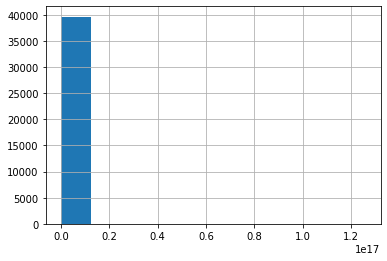

In [ ]:
df['momentum_price'].hist()

Можно увидеть, что количество не везде совпадает - значит отсутствующие данные есть.
Признаки в разных измерениях. В max и min видно, что есть выбросы

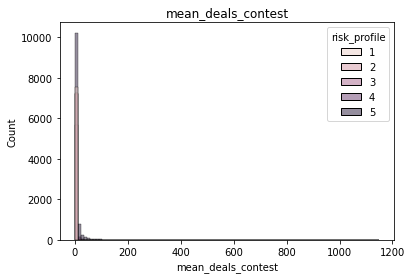

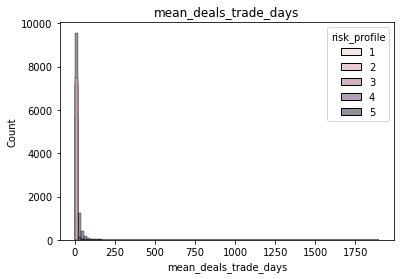

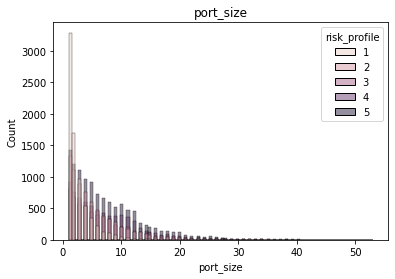

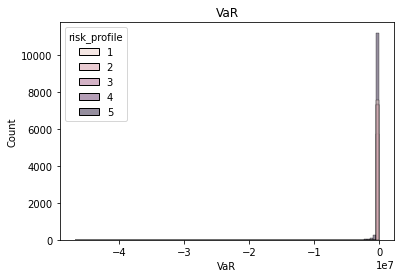

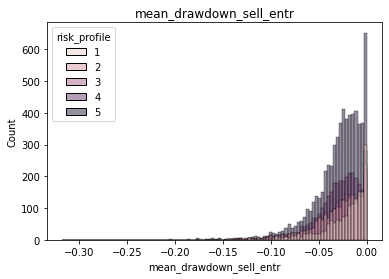

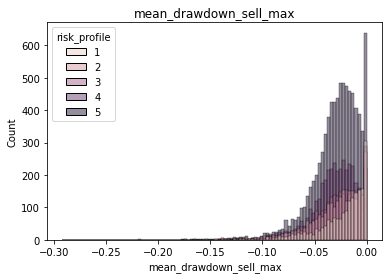

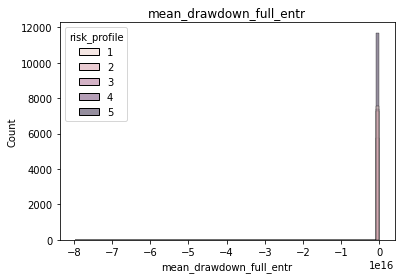

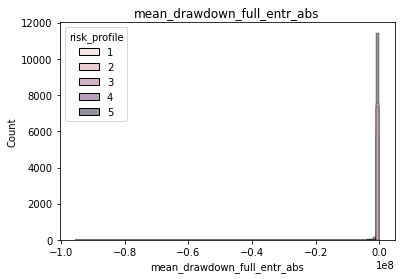

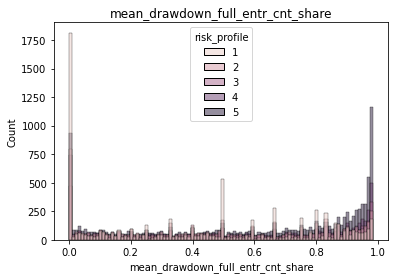

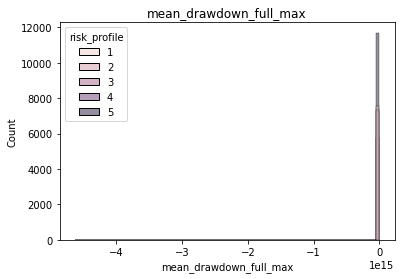

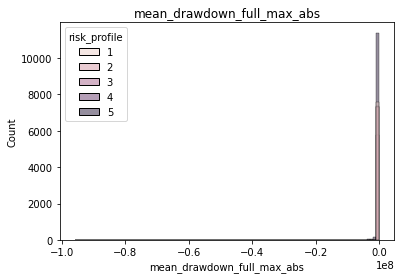

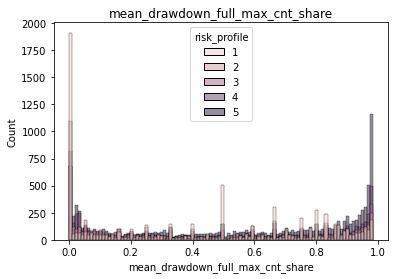

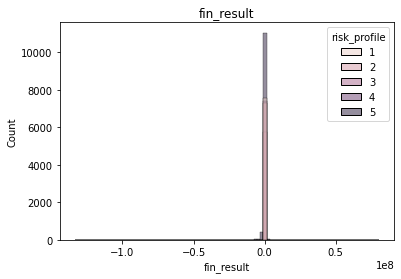

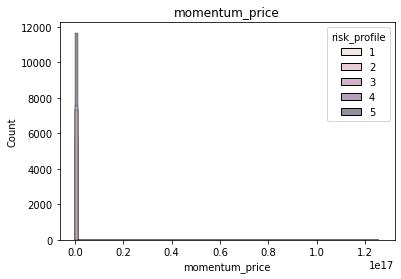

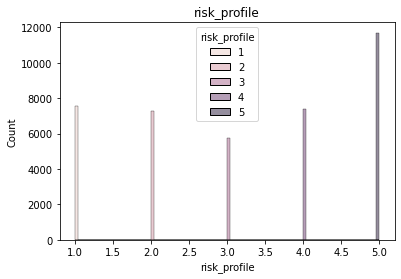

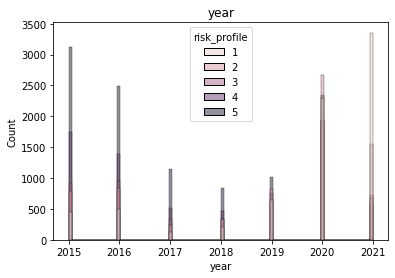

In [ ]:
for col in df.columns:
    #plt.subplot(4, 4, i+1)
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x= col, hue='risk_profile', bins=100)
    plt.title(col)
    plt.show()

Разные распределения у признаков.
По графику риск-профилями видно что наш датасет сбалансированный по риск-профилям

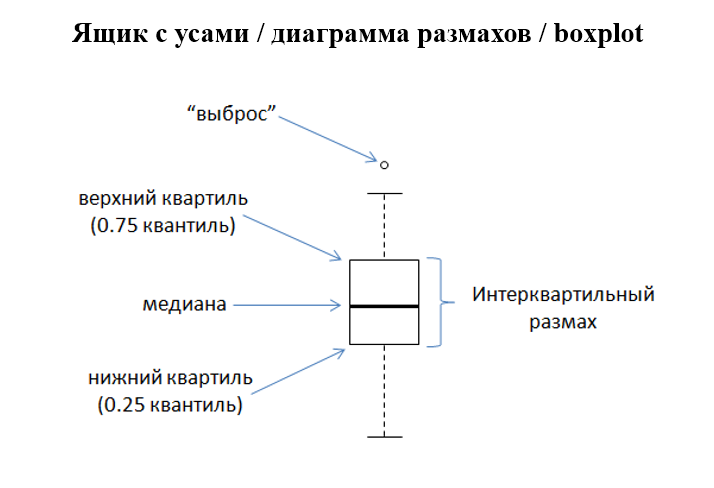

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


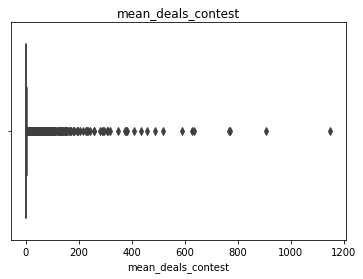

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


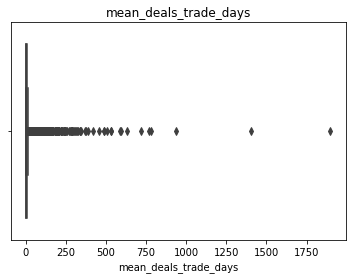

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


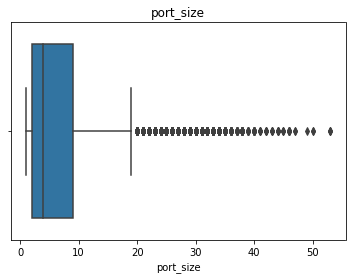

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


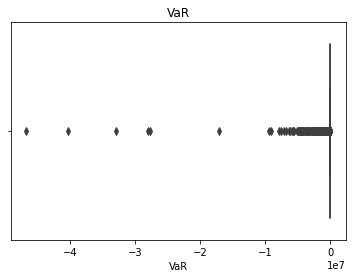

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


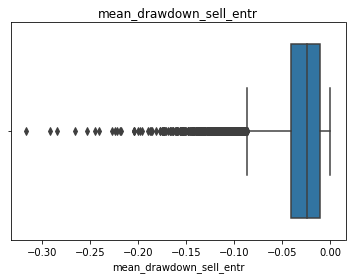

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


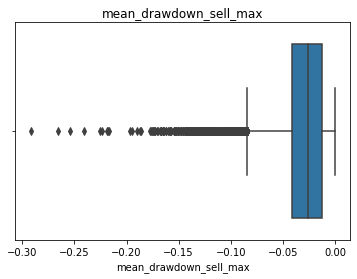

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


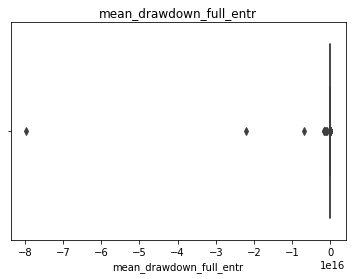

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


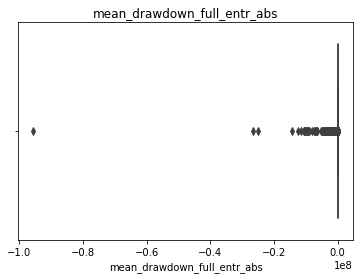

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


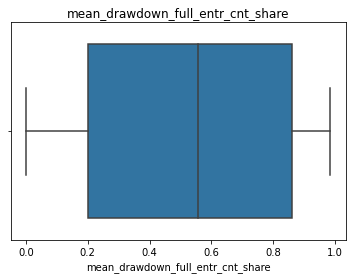

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


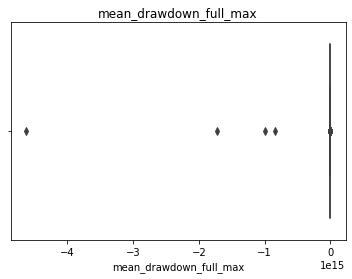

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


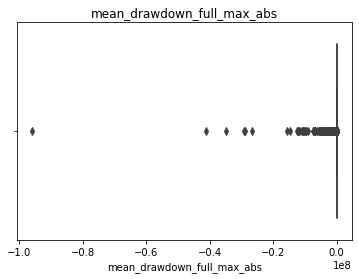

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


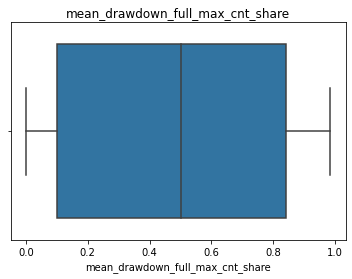

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


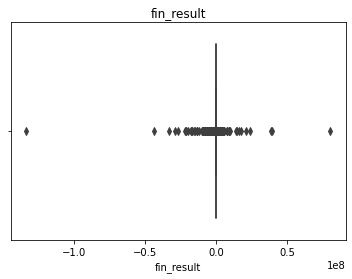

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


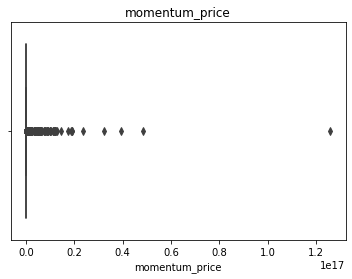

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


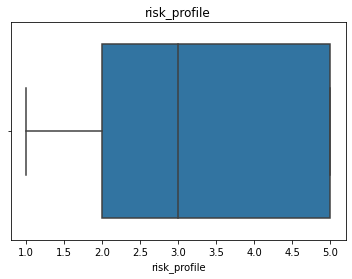

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


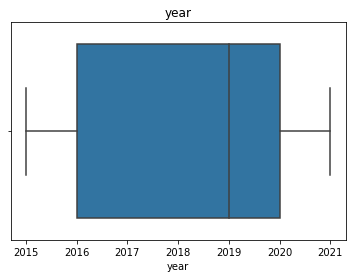

In [ ]:
for col in df.columns:
  #plt.subplot(4, 4, i+1)
  plt.figure(figsize=(6, 4))
  sns.boxplot(df[col])
  plt.title(col)
  plt.show()

## 5. Анализ пропущенных значений

Посмотрим на концентрацию пропусков в датасете

In [ ]:
df.isnull().mean() * 100

mean_deals_contest                    0.000000
mean_deals_trade_days                 0.000000
port_size                             0.000000
VaR                                   0.000000
mean_drawdown_sell_entr              60.081651
mean_drawdown_sell_max               51.173106
mean_drawdown_full_entr               0.000000
mean_drawdown_full_entr_abs           0.000000
mean_drawdown_full_entr_cnt_share     0.000000
mean_drawdown_full_max                0.000000
mean_drawdown_full_max_abs            0.000000
mean_drawdown_full_max_cnt_share      0.000000
fin_result                            0.000000
momentum_price                        0.000000
risk_profile                          0.000000
year                                  0.000000
dtype: float64

В sell_drawdown_entr_pct и sell_drawdown_max_pct пропусков больше, чем 50%
Поэтому удаляем эти признаки по причине неинформативности

In [ ]:
df=df.drop(['mean_drawdown_sell_entr','mean_drawdown_sell_max' ], axis=1)

## 6. Попарное сравнение фич

### Корреляция

Text(0.5, 1.0, 'Correlation Heatmap')

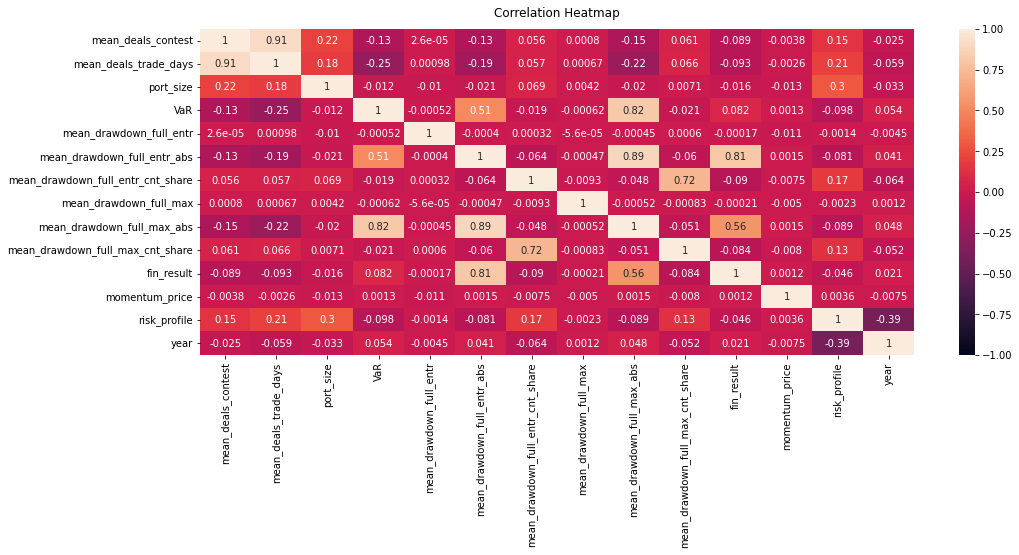

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [ ]:
df_cor = df.corr()

all_features = list(df_cor.columns)
df_cor = df_cor.values
y_ind = all_features.index('risk_profile')
protected_features = ['risk_profile']
threshold = 0.7

features_to_del = []

for i in range(len(all_features)):
    if (all_features[i] == y_ind) or (all_features[i] in features_to_del)  or (all_features[i] in protected_features):
        continue
    for j in range(len(all_features)):
        if (j >= i) or (j == y_ind) or (all_features[j] in features_to_del) or (all_features[i] in features_to_del)\
         or (all_features[i] in protected_features):
            continue
        if abs(df_cor[i, j]) >= threshold:
            if abs(df_cor[y_ind, i]) > abs(df_cor[y_ind, j]):
                features_to_del.append(all_features[j])
            else:
                features_to_del.append(all_features[i])

features_to_del

['mean_deals_contest',
 'mean_drawdown_full_max_abs',
 'mean_drawdown_full_max_cnt_share',
 'fin_result']

### Попарные графики

In [ ]:
df.columns

Index(['mean_deals_contest', 'mean_deals_trade_days', 'port_size', 'VaR',
       'mean_drawdown_full_entr', 'mean_drawdown_full_entr_abs',
       'mean_drawdown_full_entr_cnt_share', 'mean_drawdown_full_max',
       'mean_drawdown_full_max_abs', 'mean_drawdown_full_max_cnt_share',
       'fin_result', 'momentum_price', 'risk_profile', 'year'],
      dtype='object')

In [ ]:
cols = list(df.columns)
cols.remove('risk_profile')
#.remove('risk_profile')
cols

['mean_deals_contest',
 'mean_deals_trade_days',
 'port_size',
 'VaR',
 'mean_drawdown_full_entr',
 'mean_drawdown_full_entr_abs',
 'mean_drawdown_full_entr_cnt_share',
 'mean_drawdown_full_max',
 'mean_drawdown_full_max_abs',
 'mean_drawdown_full_max_cnt_share',
 'fin_result',
 'momentum_price',
 'year']

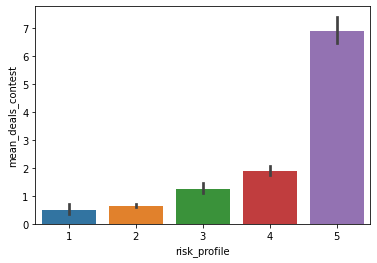

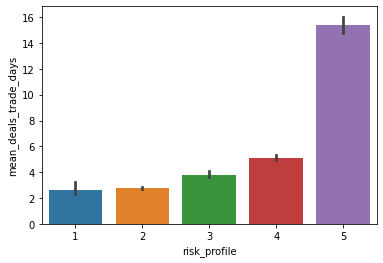

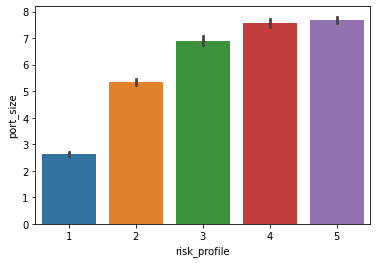

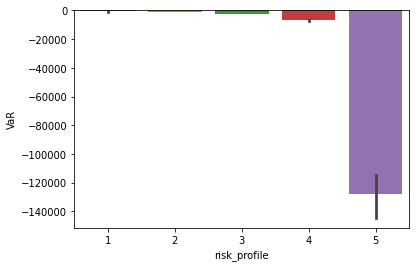

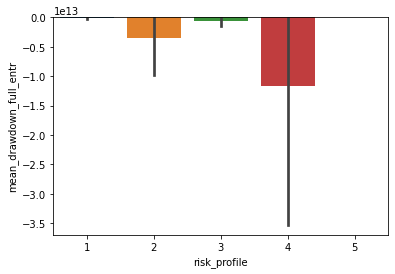

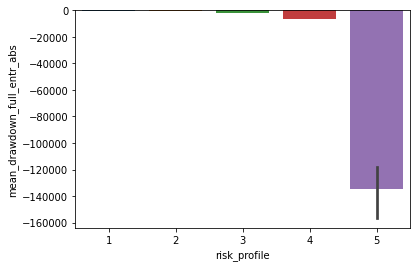

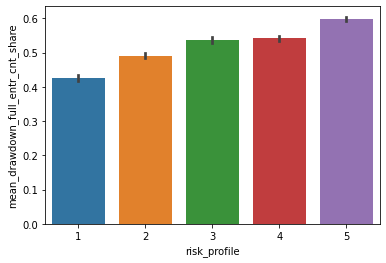

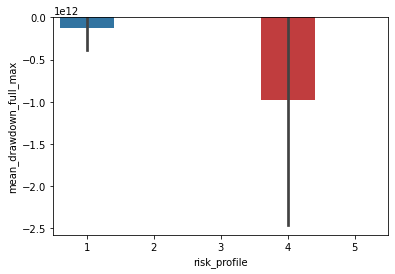

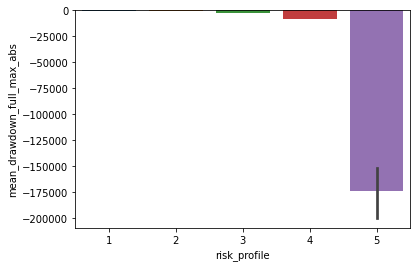

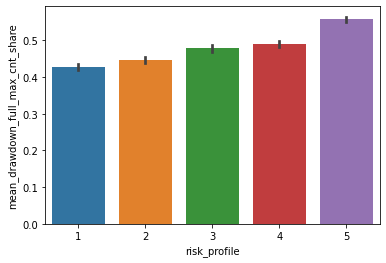

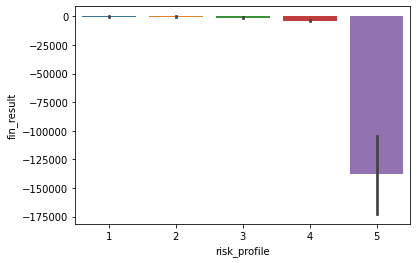

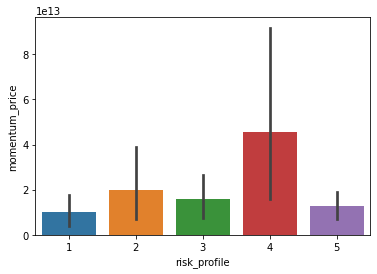

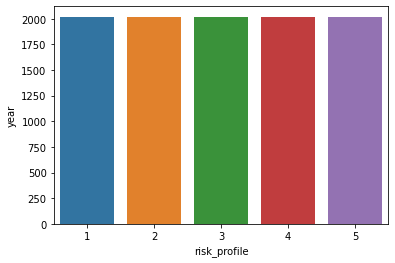

In [ ]:
cols = list(df.columns)
cols.remove('risk_profile')

for col in cols:
    sns.barplot(data=df, y = col, x = 'risk_profile')
    plt.show()

## 7. Выявление выбросов

Расчет выбросов по пределам в 3 СКО будет не ок, потому что у нас не везде нормальное распределение в признаках, DBSCAN и изоляционный лес что-то страшное для меня, а вот метод боксплотов кажется подходящим

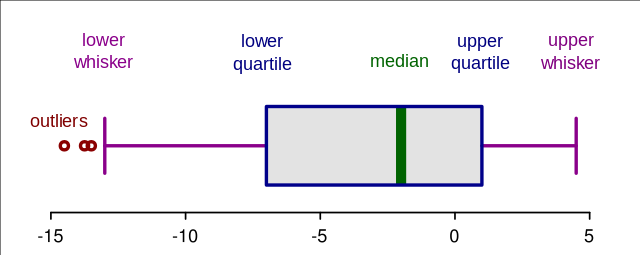

Любые точки данных, которые показывают выше или ниже усов, могут считаться выбросами или аномальными. Нижняя граница - 5%, верхняя - 95%

In [ ]:
for col in df.columns:
    # считаем квартили
    q5,q95 = np.percentile(df.loc[:,col],[5,95])
    # границы
    max = q95
    min = q5
    # буду помечать выбросы нанками, чтобы было удобно посмотреть процент выбросов и быстро дропнуть
    df.loc[df[col] < min, col] = np.nan
    df.loc[df[col] > max, col] = np.nan

смотрим процент выбросов


In [ ]:
df.isnull().mean() * 100

mean_deals_contest                   9.677175
mean_deals_trade_days                4.999874
port_size                            4.687382
VaR                                  9.999748
mean_drawdown_full_entr              4.999874
mean_drawdown_full_entr_abs          4.999874
mean_drawdown_full_entr_cnt_share    4.838588
mean_drawdown_full_max               4.999874
mean_drawdown_full_max_abs           4.999874
mean_drawdown_full_max_cnt_share     4.838588
fin_result                           9.999748
momentum_price                       9.994708
risk_profile                         0.000000
year                                 0.000000
dtype: float64

дропаем все, что посчитали выбросами

In [ ]:
df=df.dropna()
df.shape

(24284, 14)

# Предобработка данных (Data preprocessing)

## 0. Обработка NaN и выбросов

обработано в EDA

## 1. Отбор фич

In [ ]:
features_to_del # сюда мы записывали сильнокоррелированные фичи

['mean_deals_contest',
 'mean_drawdown_full_max_abs',
 'mean_drawdown_full_max_cnt_share',
 'fin_result']

In [ ]:
df = df.drop(columns = features_to_del, axis=1)

In [ ]:
df.shape

(24284, 10)

## 2. Feature Engineering

- получение данных из внешних источников (обогащение данных) - нет
- получение данных из domain-аналитики (есть выручка, есть затраты, можно посчитать прибыль) - нет
- математическая генерация (погуглить и сделать)


### Математическая генерация

In [ ]:
# TO DO: protected_cols
def add_poly_features(df, degree=2):
    
    y_col = df['risk_profile'].values
    year_col = df['year'].values

    df = df.drop('risk_profile', axis=1)
    df_values = df.values
    poly = PolynomialFeatures(2)
    df_values = poly.fit_transform(df_values)
    num_new_cols = len(df_values[0])
    cols = [ f"g_{i}"  for i in range(num_new_cols)]

    new_df = pd.DataFrame(data=df_values, index = df.index, columns = cols)

    # merging original columns with generated to find duplicates
    all_df = pd.concat([new_df, df], axis=1)
    
    # deleting duplicated columns
    df_wout_dup = all_df.loc[:,~all_df.columns.duplicated()]
    #print(df_wout_dup.columns)

    # adding original columns
    # new_df = pd.concat([df_wout_dup, df], axis =1)
    df_wout_dup['risk_profile'] = y_col
    df_wout_dup['year'] = year_col

    return df_wout_dup

In [ ]:
df = add_poly_features(df)
df.head(10)

,g_0,g_1,g_2,g_3,g_4,g_5,g_6,g_7,g_8,g_9,...,mean_deals_trade_days,port_size,VaR,mean_drawdown_full_entr,mean_drawdown_full_entr_abs,mean_drawdown_full_entr_cnt_share,mean_drawdown_full_max,momentum_price,year,risk_profile
1_62009,1.0,2.666667,2.0,-3917.212,-3.893488,-5031.165333,0.714286,-4.982029,21.278788,2015.0,...,2.666667,2.0,-3917.212,-3.893488,-5031.165333,0.714286,-4.982029,21.278788,2015.0,4.0
1_62125,1.0,1.473684,1.0,-14113.100,-17.259298,-3797.045455,0.611111,-1.876541,31.448554,2015.0,...,1.473684,1.0,-14113.100,-17.259298,-3797.045455,0.611111,-1.876541,31.448554,2015.0,4.0
1_55070,1.0,4.000000,8.0,-3379.600,-0.038421,-7.300000,0.037037,-0.294324,1.892929,2015.0,...,4.000000,8.0,-3379.600,-0.038421,-7.300000,0.037037,-0.294324,1.892929,2015.0,3.0
1_57920,1.0,2.571429,3.0,-7093.500,-2.820647,-7728.571429,0.897436,-8.876011,6.320573,2015.0,...,2.571429,3.0,-7093.500,-2.820647,-7728.571429,0.897436,-8.876011,6.320573,2015.0,4.0
1_58298,1.0,2.714286,3.0,-9034.810,-12.106771,-1452.812500,0.372093,-1.691423,13.650660,2015.0,...,2.714286,3.0,-9034.810,-12.106771,-1452.812500,0.372093,-1.691423,13.650660,2015.0,4.0
1_53786,1.0,7.800000,14.0,-18965.448,-10.961978,-31768.470400,0.909091,-3.722314,4.162887,2015.0,...,7.800000,14.0,-18965.448,-10.961978,-31768.470400,0.909091,-3.722314,4.162887,2015.0,5.0
1_58473,1.0,17.590909,3.0,-72272.580,-1.096816,-8092.421429,0.325581,-0.559294,71.525051,2015.0,...,17.590909,3.0,-72272.580,-1.096816,-8092.421429,0.325581,-0.559294,71.525051,2015.0,5.0
1_49000,1.0,2.250000,2.0,-1542.800,0.000000,0.000000,0.000000,-0.200116,3.145344,2015.0,...,2.250000,2.0,-1542.800,0.000000,0.000000,0.000000,-0.200116,3.145344,2015.0,3.0
1_58344,1.0,3.000000,5.0,-11525.584,0.000000,0.000000,0.000000,-0.284235,19.715746,2015.0,...,3.000000,5.0,-11525.584,0.000000,0.000000,0.000000,-0.284235,19.715746,2015.0,5.0
1_57306,1.0,12.866667,4.0,-34841.000,-31.901644,-54232.794118,0.850000,-9.469517,38.352941,2015.0,...,12.866667,4.0,-34841.000,-31.901644,-54232.794118,0.850000,-9.469517,38.352941,2015.0,5.0


#### Отбор фич с математической генерацией

In [ ]:
df_cor = df.corr()

all_features = list(df_cor.columns)
df_cor = df_cor.values
y_ind = all_features.index('risk_profile')
protected_features = ['risk_profile']
threshold = 0.7

features_to_del = []

for i in range(len(all_features)):
    if (all_features[i] == y_ind) or (all_features[i] in features_to_del)  or (all_features[i] in protected_features):
        continue
    for j in range(len(all_features)):
        if (j >= i) or (j == y_ind) or (all_features[j] in features_to_del) or (all_features[i] in features_to_del)\
         or (all_features[i] in protected_features):
            continue
        if abs(df_cor[i, j]) >= threshold:
            if abs(df_cor[y_ind, i]) > abs(df_cor[y_ind, j]):
                features_to_del.append(all_features[j])
            else:
                features_to_del.append(all_features[i])

features_to_del

['g_5',
 'g_10',
 'g_11',
 'g_12',
 'g_4',
 'g_15',
 'g_7',
 'g_18',
 'g_19',
 'g_20',
 'g_8',
 'g_26',
 'g_27',
 'g_29',
 'g_30',
 'g_3',
 'g_34',
 'g_35',
 'g_36',
 'g_39',
 'g_40',
 'g_14',
 'g_22',
 'g_42',
 'g_43',
 'g_44',
 'g_6',
 'g_46',
 'g_48',
 'g_49',
 'g_51',
 'g_52',
 'g_53',
 'g_9',
 'mean_deals_trade_days',
 'port_size',
 'VaR',
 'mean_drawdown_full_entr',
 'mean_drawdown_full_entr_abs',
 'mean_drawdown_full_entr_cnt_share',
 'mean_drawdown_full_max',
 'momentum_price',
 'year']

In [ ]:
df = df.drop(columns = features_to_del[:-1], axis=1)

In [ ]:
#df = df.drop(columns = ['momentum_price'], axis=1)

In [ ]:
df.shape

(24284, 23)

## 3. Train-test split + Трансформация фич (Шкалирование)

Делим на train и test, на train fit_transform, на test - transform от train

In [ ]:
df.columns

Index(['g_0', 'g_1', 'g_2', 'g_13', 'g_16', 'g_17', 'g_21', 'g_23', 'g_24',
       'g_25', 'g_28', 'g_31', 'g_32', 'g_33', 'g_37', 'g_38', 'g_41', 'g_45',
       'g_47', 'g_50', 'g_54', 'year', 'risk_profile'],
      dtype='object')

In [ ]:
X = df.drop('risk_profile', axis=1).values
y = df['risk_profile'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=df['year'].values)

In [ ]:
scaler = StandardScaler()

In [ ]:
df.head(10)

,g_0,g_1,g_2,g_13,g_16,g_17,g_21,g_23,g_24,g_25,...,g_33,g_37,g_38,g_41,g_45,g_47,g_50,g_54,year,risk_profile
1_62009,1.0,2.666667,2.0,-10.382635,-13.285411,56.743434,-7.786976,1.428571,-9.964058,42.557576,...,-7.893182e+06,19.397471,-82.848708,-3593.689524,0.510204,15.199134,-106.011541,4060225.0,2015.0,4.0
1_62125,1.0,1.473684,1.0,-25.434754,-2.765429,46.345237,-17.259298,0.611111,-1.876541,31.448554,...,-2.843790e+07,32.387784,-542.779947,-2320.416667,0.373457,19.218561,-59.014508,4060225.0,2015.0,4.0
1_55070,1.0,4.000000,8.0,-0.153684,-1.177298,7.571718,-0.307368,0.296296,-2.354596,15.143435,...,-6.809894e+06,0.011308,-0.072728,-0.270370,0.001372,0.070108,-0.557135,4060225.0,2015.0,3.0
1_57920,1.0,2.571429,3.0,-7.253091,-22.824028,16.252903,-8.461940,2.692308,-26.628032,18.961720,...,-1.429340e+07,25.036089,-17.828103,-6935.897436,0.805391,5.672309,-56.101477,4060225.0,2015.0,4.0
1_58298,1.0,2.714286,3.0,-32.861235,-4.591006,37.051793,-36.320312,1.116279,-5.074270,40.951981,...,-1.820514e+07,20.477675,-165.265418,-540.581395,0.138453,5.079316,-23.089046,4060225.0,2015.0,4.0
1_53786,1.0,7.800000,14.0,-85.503430,-29.034048,32.470516,-153.467694,12.727273,-52.112393,58.280414,...,-3.821538e+07,40.803923,-45.633473,-28880.427636,0.826446,3.784442,-15.495571,4060225.0,2015.0,5.0
1_58473,1.0,17.590909,3.0,-19.293998,-9.838483,1258.190676,-3.290449,0.976744,-1.677881,214.575154,...,-1.456292e+08,0.613442,-78.449853,-2634.741860,0.106003,23.287226,-40.003504,4060225.0,2015.0,5.0
1_49000,1.0,2.250000,2.0,0.000000,-0.450261,7.077024,0.000000,0.000000,-0.400232,6.290688,...,-3.108742e+06,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.629434,4060225.0,2015.0,3.0
1_58344,1.0,3.000000,5.0,0.000000,-0.852706,59.147239,0.000000,0.000000,-1.421177,98.578732,...,-2.322405e+07,-0.000000,0.000000,0.000000,0.000000,0.000000,-5.603913,4060225.0,2015.0,5.0
1_57306,1.0,12.866667,4.0,-410.467814,-121.841121,493.474510,-127.606574,3.400000,-37.878069,153.411765,...,-7.020461e+07,302.093163,-1223.521860,-46097.875000,0.722500,32.600000,-363.183836,4060225.0,2015.0,5.0


# MODELING

В рамках моделирования будем использовать:
- pipeline (шкалирование + инициализация модели)
- gridSearchCV на train (поиск лучших параметров по сетке с проверкой на 5-фолдовой кросс-валидации)
- захардкоженная ниже calculate_test_metrics (для расчета метрик классификации на тестовом сете)
- запись в таблицу с результатами

In [ ]:
def calculate_test_metrics(X_test, clf):

    test_predictions = clf.best_estimator_.predict(X_test)
    mse = metrics.mean_squared_error(y_test, test_predictions)
    accuracy = metrics.accuracy_score(y_test,test_predictions)
    precision = metrics.precision_score(y_test, test_predictions, average='weighted')
    recall = metrics.recall_score(y_test, test_predictions, average='weighted')
    f1 =  metrics.f1_score(y_test, test_predictions, average='weighted')

    print(f'Accuracy: {round(accuracy, 4)}')
    print(f'Precision: {round(precision, 4)}')
    print(f'Recall: {round(recall, 4)}')
    print(f'F1: {round(f1, 4)}')
    print(f'MSE: {round(mse, 4)}')
    
    return round(accuracy, 4), round(precision, 4), round(recall, 4), round(f1, 4), round(mse, 4)

## KNN

Алгоритм имеет две фазы: **обучение** и **классификация**. 

На обучении он запоминает расположение и метки классов обучающего множества

На классификации алгоритм берет новый объект, смотрит на его k ближайших соседей по заданной метрике и определяет, в какой класс объект нужно отнести

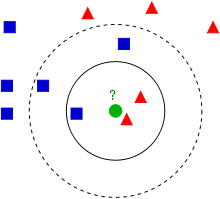

Алгоритм KNN является чувствительным к дисбалансу классов в обучающих данных (здесь мы подготовились)

Какие параметры будем тюнить:
* **metric** - способ подсчета расстояние до других объектов
* **k** - число соседей, которе будет использоваться при классификации (инсайт: надо брать нечетное)
* **weights** - функция весов


In [ ]:
y_train

array([3., 4., 3., ..., 3., 2., 1.])

In [ ]:
classifier = sklearn.neighbors.KNeighborsClassifier()
pipeline = Pipeline(steps = [('scaling', scaler), ('classifier', classifier)])

In [ ]:
param_grid = {'classifier__n_neighbors': [3, 5, 9, 11, 15, 17, 19],
              'classifier__weights': ["uniform", "distance"],
              'classifier__metric': ["euclidean", "manhattan"]}

clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted')
clf.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_)

Pipeline(steps=[('scaling', StandardScaler()),
                ('classifier',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=17,
                                      weights='distance'))])
0.7605600937372171
{'classifier__metric': 'manhattan', 'classifier__n_neighbors': 17, 'classifier__weights': 'distance'}


In [ ]:
accuracy,precision,recall,f1, mse = calculate_test_metrics(X_test,clf)

Accuracy: 0.757
Precision: 0.7608
Recall: 0.757
F1: 0.7573
MSE: 0.285


In [ ]:
results.loc['KNN'] = [ clf.best_params_,
                mse, accuracy, precision, recall,  f1]

In [ ]:
results

,hyperparams,MSE,Accuracy,precision,recall,f1-score
KNN,"{'classifier__metric': 'manhattan', 'classifie...",0.285,0.757,0.7608,0.757,0.7573


## Логистическая регрессия

'lfbgs' - ['l2']

Software for Large-scale Bound-constrained Optimization
Ciyou Zhu, Richard Byrd, Jorge Nocedal and Jose Luis Morales. http://users.iems.northwestern.edu/~nocedal/lbfgsb.html

In [ ]:
classifier = linear_model.LogisticRegression(random_state=1, max_iter=10000)
pipeline = Pipeline(steps = [('scaling', scaler), ('classification', classifier)])

In [ ]:
tuned_parameters_lbfgs = {'classification__C': [0.1, 0.5, 1, 5, 10, 30],
                    'classification__penalty': ['l2'],
                    'classification__multi_class': ['auto', 'ovr', 'multinomial'],
                    'classification__solver': ['lbfgs']}

log_model = GridSearchCV(pipeline, tuned_parameters_lbfgs, cv=5, scoring='f1_weighted')
log_model.fit(X_train, y_train)
print(log_model.best_estimator_)
print(log_model.best_score_)
print(log_model.best_params_)

Pipeline(steps=[('scaling', StandardScaler()),
                ('classification',
                 LogisticRegression(C=30, max_iter=10000, random_state=1))])
0.6945957403829432
{'classification__C': 30, 'classification__multi_class': 'auto', 'classification__penalty': 'l2', 'classification__solver': 'lbfgs'}


In [ ]:
accuracy,precision,recall,f1, mse = calculate_test_metrics(X_test,clf)

Accuracy: 0.757
Precision: 0.7608
Recall: 0.757
F1: 0.7573
MSE: 0.285


In [ ]:
results.loc['LogisticRegression'] = [ clf.best_params_,
                mse, accuracy, precision, recall,  f1]

In [ ]:
results

,hyperparams,MSE,Accuracy,precision,recall,f1-score
KNN,"{'classifier__metric': 'manhattan', 'classifie...",0.285,0.757,0.7608,0.757,0.7573
LogisticRegression,"{'classifier__metric': 'manhattan', 'classifie...",0.285,0.757,0.7608,0.757,0.7573


##[CANCELED] SVM

Суть алгоритма в нахождении уравнения разделяющей гиперплоскости. Опорные вектора в этом алгоритме это такие вектора, которые создают зазор - максимальное расстояние между друг другом.

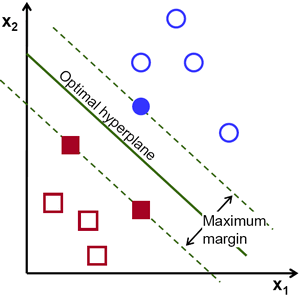


Будем тюнить 3 параметра:
* **kernel** - ядро (может быть линейным, заданным радиально-базисной функцией т.е. строить сложные границы, полиномиальным)
* **gamma** - гамма-параметр, определяет насколько далеко каждый из элементов в наборе данных имеет влияние при определении “идеальной гиперлинии”.
* **C** - параметр регуляризации

Согласно документации SVM в sklearn:

> Многие элементы, используемые в целевой функции алгоритма обучения (например, ядро RBF машин опорных векторов или регуляризаторы l1 и l2 линейных моделей), предполагают, что все объекты сосредоточены вокруг нуля и имеют дисперсию в том же порядке. Если у признака есть отклонение, которое на несколько порядков больше, чем у других, оно может доминировать в целевой функции и сделать оценщика неспособным учиться на других признаках правильно, как ожидалось.



Значит снова StandardScaler() используем

In [ ]:
classifier = SVC()
pipeline = Pipeline(steps = [('scaling', scaler), ('classifier', classifier)])

In [ ]:
param_grid = {'classifier__C': [0.1, 1, 10, 100, 1000],
              'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'classifier__kernel': ['linear', 'rbf', 'poly']}

clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted')
clf.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_)

In [ ]:
accuracy,precision,recall,f1, mse = calculate_test_metrics(X_test,clf)

Решили забить, так как нигде не считался нормально - ни в колабе, ни на локалке, ни на суперкомпе

##Случайный лес (бэггинг)

Случайный лес представляет собой **ансамбль из деревьев решений**, каждое дерево обучается и предсказывает результат на одних и тех же данных независимо друг от друга, далее берется среднее от результатов по каждому дереву

Это позволяет усреднить ошибку предсказания, вызванную наличием случайной составляющей в дереве решений


In [ ]:
# кол-во деревьев  -  корень из кол-ва признаков = 3
classifier = sklearn.ensemble.RandomForestClassifier(n_estimators=3)
pipeline = Pipeline(steps = [('classification', classifier)])

In [ ]:
%%time
tuned_parameters_rf = {
                       'classification__criterion' : ['gini', 'entropy'],
                       'classification__max_features': ['auto', 'sqrt', 'log2'],
                       "classification__max_features"      : [3, 5],
                       "classification__max_depth"         : [10, 20],
                       "classification__min_samples_split" : [2, 4] ,
                       "classification__bootstrap": [True, False]}

clf = GridSearchCV(pipeline, tuned_parameters_rf, cv=5, scoring='f1_weighted')
clf.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_)

Pipeline(steps=[('classification',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_depth=10, max_features=5,
                                        n_estimators=3))])
0.7970929012169468
{'classification__bootstrap': False, 'classification__criterion': 'entropy', 'classification__max_depth': 10, 'classification__max_features': 5, 'classification__min_samples_split': 2}
CPU times: user 45.3 s, sys: 110 ms, total: 45.4 s
Wall time: 45.7 s


In [ ]:
accuracy,precision,recall,f1, mse = calculate_test_metrics(X_test,clf)

Accuracy: 0.7877
Precision: 0.79
Recall: 0.7877
F1: 0.7883
MSE: 0.2354


In [ ]:
results.loc['RandomForest'] = [ clf.best_params_,
                mse, accuracy, precision, recall,  f1]

In [ ]:
results

,hyperparams,MSE,Accuracy,precision,recall,f1-score
KNN,"{'classifier__metric': 'manhattan', 'classifie...",0.2850,0.7570,0.7608,0.7570,0.7573
LogisticRegression,"{'classifier__metric': 'manhattan', 'classifie...",0.2850,0.7570,0.7608,0.7570,0.7573
RandomForest,"{'classification__bootstrap': False, 'classifi...",0.2354,0.7877,0.7900,0.7877,0.7883


#### тюнинг: увеличиваем количество фич для леса

In [ ]:
%%time
tuned_parameters_rf = {
                       'classification__criterion' : ['gini', 'entropy'],
                       'classification__max_features': ['auto', 'sqrt', 'log2'],
                       "classification__max_features"      : [3, 5, 10 , 15, 20],
                       "classification__max_depth"         : [5, 10 , 20],
                       "classification__min_samples_split" : [2, 4, 7] ,
                       "classification__bootstrap": [True, False]}

clf = GridSearchCV(pipeline, tuned_parameters_rf, cv=5, scoring='f1_weighted')
clf.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_)

Pipeline(steps=[('classification',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=15, min_samples_split=7,
                                        n_estimators=3))])
0.8321411917223595
{'classification__bootstrap': False, 'classification__criterion': 'gini', 'classification__max_depth': 10, 'classification__max_features': 15, 'classification__min_samples_split': 7}
CPU times: user 7min 41s, sys: 739 ms, total: 7min 42s
Wall time: 7min 47s


In [ ]:
accuracy,precision,recall,f1, mse = calculate_test_metrics(X_test,clf)

Accuracy: 0.8318
Precision: 0.834
Recall: 0.8318
F1: 0.8325
MSE: 0.1769


In [ ]:
results.loc['RandomForest_15feat'] = [ clf.best_params_,
                mse, accuracy, precision, recall,  f1]

In [ ]:
results

,hyperparams,MSE,Accuracy,precision,recall,f1-score
KNN,"{'classifier__metric': 'manhattan', 'classifie...",0.2850,0.7570,0.7608,0.7570,0.7573
LogisticRegression,"{'classifier__metric': 'manhattan', 'classifie...",0.2850,0.7570,0.7608,0.7570,0.7573
RandomForest,"{'classification__bootstrap': False, 'classifi...",0.2354,0.7877,0.7900,0.7877,0.7883
RandomForest_15feat,"{'classification__bootstrap': False, 'classifi...",0.1769,0.8318,0.8340,0.8318,0.8325


## Градиентный бустинг

Последовательное построение композиции алгоритмов
b0 + b1 = y

Строится базовый алгоритм b0, далее определяется сдвиг как y - b0, на основе чего строится следующий алгоритм, определяется следующий сдвиг и так далее

Градиентный бустинг определяет сдвиг через антиградиент, так как сдвиг должен стремиться к нулю.


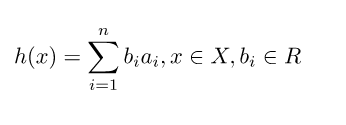

бустинг

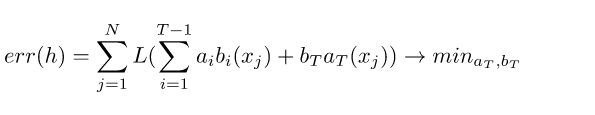

### Scikit-learn Gradient Boosting

In [ ]:
classifier = sklearn.ensemble.GradientBoostingClassifier()
pipeline = Pipeline(steps = [('scaling', scaler), ('classifier', classifier)])
 

param_grid = {
    "classifier__loss":["deviance"],
    "classifier__learning_rate": [0.01, 0.025, 0.05, 0.1, 0.15],
    "classifier__max_depth":[5,6, 7, 8], 
    "classifier__max_features":["log2","sqrt"],
    "classifier__criterion": ["friedman_mse"],
    "classifier__subsample":[0.5, 0.8, 0.9, 1.0],
    "classifier__n_estimators":[10]
    }

clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted')
clf.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_)

Pipeline(steps=[('scaling', StandardScaler()),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.15, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=10))])
0.8199226272672984
{'classifier__criterion': 'friedman_mse', 'classifier__learning_rate': 0.15, 'classifier__loss': 'deviance', 'classifier__max_depth': 8, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 10, 'classifier__subsample': 1.0}


In [ ]:
accuracy,precision,recall,f1, mse = calculate_test_metrics(X_test,clf)

Accuracy: 0.8236
Precision: 0.825
Recall: 0.8236
F1: 0.8241
MSE: 0.1866


In [ ]:
results.loc['GradientBoosting(sklearn)'] = [ clf.best_params_,
                mse, accuracy, precision, recall,  f1]

In [ ]:
results

,hyperparams,MSE,Accuracy,precision,recall,f1-score
KNN,"{'classifier__metric': 'manhattan', 'classifie...",0.2850,0.7570,0.7608,0.7570,0.7573
LogisticRegression,"{'classifier__metric': 'manhattan', 'classifie...",0.2850,0.7570,0.7608,0.7570,0.7573
RandomForest,"{'classification__bootstrap': False, 'classifi...",0.2354,0.7877,0.7900,0.7877,0.7883
RandomForest_15feat,"{'classification__bootstrap': False, 'classifi...",0.1769,0.8318,0.8340,0.8318,0.8325
GradientBoosting(sklearn),"{'classifier__criterion': 'friedman_mse', 'cla...",0.1866,0.8236,0.8250,0.8236,0.8241


### XGboost

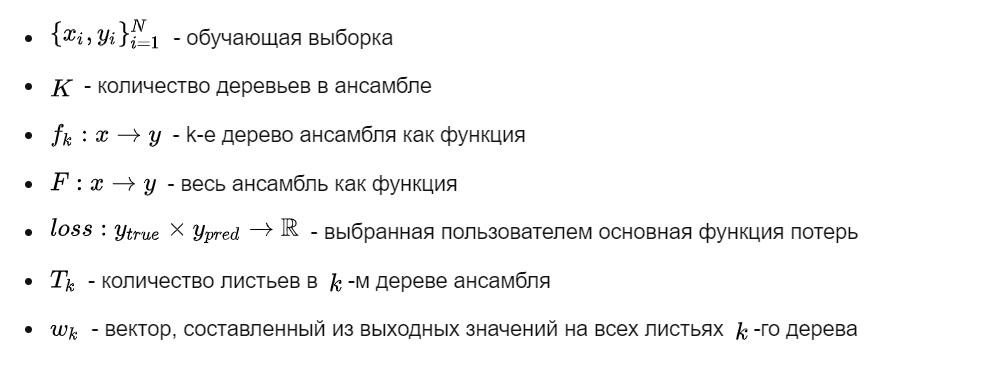

В XGBoost ответы суммируются по всем деревьям ансамбля:

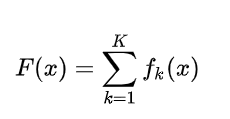

Суммарная функция потерь в XGBoost выглядит воть так:

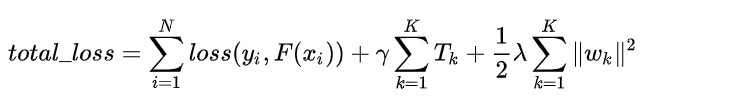

Здесь \gamma, \lambda - гиперпараметры. 
Первое слагаемое - это основная функция потерь, 
второе слагаемое штрафует деревья за слишком большое количество листьев, третье слагаемое - за слишком большие предсказание, оно обеспечивает то, что каждое дерево вносит минимальный вклад в результат. 

Функция потерь используется при построении каждого следующего дерева, то есть функция потерь оптимизируется по параметрам лишь последнего дерева, не затрагивая предыдущие.

In [ ]:
# зафиксировать без гаммы, а потом попробовать
scaler = StandardScaler()

In [ ]:
X_train = work_dict['X_train']
y_train = work_dict['y_train']
X_test = work_dict['X_test']
y_test = work_dict['y_test']

In [ ]:
results = work_dict['results']

In [ ]:
classifier = xgb.XGBClassifier(objective='multi:softmax') # потом попробовать softprob и по разным порогам смотреть
pipeline = Pipeline(steps = [('scaling', scaler), ('classifier', classifier)])

param_grid = [{
                "classifier__learning_rate" : [0.1, 0.5, 0.7],
                "classifier__max_depth" : [3, 5, 10, 15],
                "classifier__n_estimators": [10, 50, 100],
                "classifier__reg_lambda": [0.01, 0.05, 0.09, 1, 2]
            }]

clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted')
clf.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_)

Pipeline(steps=[('scaling', StandardScaler()),
                ('classifier',
                 XGBClassifier(max_depth=10, objective='multi:softprob'))])
0.8427799907424063
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 100, 'classifier__reg_lambda': 1}


In [ ]:
accuracy,precision,recall,f1, mse = calculate_test_metrics(X_test,clf)

Accuracy: 0.846
Precision: 0.8476
Recall: 0.846
F1: 0.8466
MSE: 0.1594


In [ ]:
results

,hyperparams,MSE,Accuracy,precision,recall,f1-score
KNN,"{'classifier__metric': 'manhattan', 'classifie...",0.2850,0.7570,0.7608,0.7570,0.7573
LogisticRegression,"{'classifier__metric': 'manhattan', 'classifie...",0.2850,0.7570,0.7608,0.7570,0.7573
RandomForest,"{'classification__bootstrap': False, 'classifi...",0.2354,0.7877,0.7900,0.7877,0.7883
RandomForest_15feat,"{'classification__bootstrap': False, 'classifi...",0.1769,0.8318,0.8340,0.8318,0.8325
GradientBoosting(sklearn),"{'classifier__criterion': 'friedman_mse', 'cla...",0.1866,0.8236,0.8250,0.8236,0.8241
XGboost,"{'classifier__learning_rate': 0.1, 'classifier...",0.1594,0.8460,0.8476,0.8460,0.8466


####тюнинг: пробуем добавить гамму

1. Подбираем параметр гамма под зафиксированные другие параметры
2. По подобранной гамме пробуем менять другие, чтобы добиться лучшего результата

In [ ]:
classifier = xgb.XGBClassifier(objective='multi:softmax') # потом попробовать softprob и по разным порогам смотреть
pipeline = Pipeline(steps = [('scaling', scaler), ('classifier', classifier)])

param_grid = [{
                "classifier__learning_rate" : [0.1], #фикс
                "classifier__max_depth" : [10], #фикс
                "classifier__n_estimators": [100], #фикс
                "classifier__reg_lambda": [1], #фикс
                "classifier__gamma": [0.1, 0.5, 0.8, 1, 2, 5, 10, 20, 100],
            }]

clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted')
clf.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_)

Pipeline(steps=[('scaling', StandardScaler()),
                ('classifier',
                 XGBClassifier(gamma=0.8, max_depth=10,
                               objective='multi:softprob'))])
0.8425466018983453
{'classifier__gamma': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 100, 'classifier__reg_lambda': 1}


In [ ]:
accuracy,precision,recall,f1, mse = calculate_test_metrics(X_test,clf)

Accuracy: 0.8475
Precision: 0.8493
Recall: 0.8475
F1: 0.8481
MSE: 0.1579


In [ ]:
results.loc['XGboost(gamma tuning)'] = [ clf.best_params_,
                mse, accuracy, precision, recall,  f1]

In [ ]:
results

,hyperparams,MSE,Accuracy,precision,recall,f1-score
KNN,"{'classifier__metric': 'manhattan', 'classifie...",0.2850,0.7570,0.7608,0.7570,0.7573
LogisticRegression,"{'classifier__metric': 'manhattan', 'classifie...",0.2850,0.7570,0.7608,0.7570,0.7573
RandomForest,"{'classification__bootstrap': False, 'classifi...",0.2354,0.7877,0.7900,0.7877,0.7883
RandomForest_15feat,"{'classification__bootstrap': False, 'classifi...",0.1769,0.8318,0.8340,0.8318,0.8325
GradientBoosting(sklearn),"{'classifier__criterion': 'friedman_mse', 'cla...",0.1866,0.8236,0.8250,0.8236,0.8241
XGboost,"{'classifier__learning_rate': 0.1, 'classifier...",0.1594,0.8460,0.8476,0.8460,0.8466
XGboost(gamma tuning),"{'classifier__gamma': 0.8, 'classifier__learni...",0.1579,0.8475,0.8493,0.8475,0.8481


### LightGBM

In [ ]:
# зафиксировать без гаммы, а потом попробовать
scaler = StandardScaler()

In [ ]:
#Converting the dataset in proper LGB format
d_train=lgb.Dataset(X_train, label=y_train)

#setting up the parameters
params={}
params['learning_rate']=0.1
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=10
params['num_class']=6 #no.of unique values in the target class not inclusive of the end value

#training the model
clf=lgb.train(params,d_train,100)  #training the model on 100 epocs ЭПОХИ ЭТО ИТЕРАЦИИ?

#prediction on the test dataset
y_pred_1=clf.predict(X_test)

y_pred_1

array([[4.68147747e-16, 8.95215889e-02, 9.08789489e-01, 6.90905653e-04,
        5.66558168e-04, 4.31458802e-04],
       [5.69544670e-16, 7.49417104e-04, 8.91412991e-01, 9.15295184e-02,
        1.57831643e-02, 5.24909203e-04],
       [1.03662917e-15, 1.36378786e-03, 4.18016791e-01, 5.66302690e-01,
        1.33613429e-02, 9.55388086e-04],
       ...,
       [3.61790541e-16, 4.76116345e-04, 4.42706143e-04, 7.44043646e-01,
        2.48047121e-01, 6.99041049e-03],
       [4.89875108e-16, 6.44675633e-04, 5.99437229e-04, 9.30464279e-01,
        6.55563930e-02, 2.73521475e-03],
       [3.20762340e-16, 4.22123233e-04, 3.92501854e-04, 8.78302601e-01,
        1.19391218e-01, 1.49155653e-03]])

In [ ]:
test_predictions = [np.argmax(line) for line in y_pred_1]
print(test_predictions)
print(y_test)
mse = metrics.mean_squared_error(y_test, test_predictions)
accuracy = metrics.accuracy_score(y_test,test_predictions)
precision = metrics.precision_score(y_test, test_predictions, average='weighted')
recall = metrics.recall_score(y_test, test_predictions, average='weighted')
f1 =  metrics.f1_score(y_test, test_predictions, average='weighted')

print(f'Accuracy: {round(accuracy, 4)}')
print(f'Precision: {round(precision, 4)}')
print(f'Recall: {round(recall, 4)}')
print(f'F1: {round(f1, 4)}')
print(f'MSE: {round(mse, 4)}')

accuracy = round(accuracy, 4)
precision = round(precision, 4)
recall =round(recall, 4)
f1 = round(f1, 4)
mse = round(mse, 4)

[2, 2, 3, 1, 2, 3, 1, 5, 5, 1, 3, 1, 3, 3, 1, 4, 1, 3, 2, 3, 5, 5, 3, 5, 5, 5, 1, 2, 1, 5, 1, 1, 5, 5, 3, 4, 2, 1, 1, 1, 2, 2, 3, 2, 4, 1, 2, 5, 1, 3, 5, 5, 5, 3, 1, 3, 5, 4, 4, 3, 3, 2, 2, 2, 4, 1, 3, 2, 2, 2, 2, 5, 3, 1, 4, 5, 3, 3, 3, 1, 2, 1, 4, 1, 1, 3, 3, 2, 2, 5, 3, 4, 3, 3, 3, 4, 5, 4, 4, 2, 1, 3, 2, 1, 2, 3, 2, 3, 2, 5, 1, 2, 4, 1, 1, 3, 2, 2, 4, 1, 3, 3, 5, 4, 3, 1, 2, 3, 1, 2, 1, 3, 1, 2, 3, 2, 3, 3, 4, 2, 2, 1, 3, 4, 2, 5, 1, 2, 2, 4, 2, 4, 3, 4, 5, 2, 4, 2, 5, 5, 4, 2, 1, 1, 2, 1, 2, 2, 5, 3, 1, 4, 1, 3, 5, 4, 4, 3, 5, 5, 4, 2, 4, 5, 2, 3, 1, 2, 2, 2, 1, 2, 1, 3, 2, 4, 4, 3, 3, 3, 1, 4, 2, 2, 1, 4, 4, 3, 2, 4, 5, 4, 3, 2, 4, 2, 4, 1, 1, 2, 2, 4, 2, 2, 1, 4, 2, 1, 3, 2, 3, 2, 3, 1, 1, 4, 3, 3, 4, 5, 4, 2, 1, 5, 3, 2, 4, 1, 4, 2, 1, 3, 3, 1, 1, 4, 4, 2, 2, 2, 3, 2, 2, 1, 5, 4, 3, 1, 1, 2, 4, 2, 4, 2, 2, 1, 2, 4, 2, 2, 1, 5, 3, 1, 3, 3, 3, 3, 1, 5, 4, 5, 2, 1, 5, 2, 3, 3, 5, 5, 1, 4, 2, 2, 3, 4, 1, 5, 5, 4, 1, 1, 4, 4, 1, 3, 3, 5, 5, 1, 1, 4, 3, 5, 2, 5, 2, 2, 2, 1, 4, 1, 1, 

In [ ]:
results.loc['LightGBM'] = [{'learning_rate' : 0.1, 'boosting_type' : 'gbdt' , 'objective':'multiclass', 'metric':'multi_logloss','max_depth': 10, 'num_class':6 } ,
                mse, accuracy, precision, recall,  f1]

In [ ]:
results

,hyperparams,MSE,Accuracy,precision,recall,f1-score
KNN,"{'classifier__metric': 'manhattan', 'classifie...",0.2850,0.7570,0.7608,0.7570,0.7573
LogisticRegression,"{'classifier__metric': 'manhattan', 'classifie...",0.2850,0.7570,0.7608,0.7570,0.7573
RandomForest,"{'classification__bootstrap': False, 'classifi...",0.2354,0.7877,0.7900,0.7877,0.7883
RandomForest_15feat,"{'classification__bootstrap': False, 'classifi...",0.1769,0.8318,0.8340,0.8318,0.8325
GradientBoosting(sklearn),"{'classifier__criterion': 'friedman_mse', 'cla...",0.1866,0.8236,0.8250,0.8236,0.8241
XGboost,"{'classifier__learning_rate': 0.1, 'classifier...",0.1594,0.8460,0.8476,0.8460,0.8466
XGboost(gamma tuning),"{'classifier__gamma': 0.8, 'classifier__learni...",0.1579,0.8475,0.8493,0.8475,0.8481
LightGBM,"{'learning_rate': 0.1, 'boosting_type': 'gbdt'...",0.1576,0.8490,0.8507,0.8490,0.8495


# Прогонка всех лучших моделей

In [ ]:
# подготовка результатов
new_results = pd.DataFrame(data=[], columns = ['hyperparams','MSE','Accuracy','precision','recall','f1-score'])
new_results

,hyperparams,MSE,Accuracy,precision,recall,f1-score


In [ ]:
# предобработка таблицы с гиперпараметрами -> приводим к виду, чтобы положить в параметры модели

for i in range(len(results)):
    model = results['hyperparams'][i]
    for key in list(model.keys()):
        model[key.replace("classifier__","").replace("classification__","")] = model[key]
        if 'classif' in key:
            del model[key]

    results['hyperparams'][i] = model
    # res[list(results['hyperparams'][i].keys()).replace("classifier__","").replace("classification__",""))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
for model in ["KNN", 'LogisticRegression','GradientBoosting(sklearn)','XGboost(gamma tuning)', 'RandomForest_15feat', 'LightGBM' ]:
    params = results['hyperparams'][model]
    
    # model pipeline (making scaling if it's not rf)
    if model == 'RandomForest_15feat':
        pipeline = sklearn.ensemble.RandomForestClassifier(n_estimators=3,**params)
    elif model == 'LightGBM':
        d_train = lgb.Dataset(X_train, label=y_train)
    else:
        if model == 'KNN':
            classifier = sklearn.neighbors.KNeighborsClassifier(**params)
        elif model == 'LogisticRegression':
            classifier = linear_model.LogisticRegression(random_state=1, max_iter=10000, **params)
        elif model == 'GradientBoosting(sklearn)':
            classifier = sklearn.ensemble.GradientBoostingClassifier(**params)
        elif model == 'XGboost(gamma tuning)':
            classifier = xgb.XGBClassifier(objective='multi:softmax',**params)
        pipeline = Pipeline(steps = [('scaling', scaler), ('classifier', classifier)])


    # fit & predict
    if model == 'LightGBM':
        classifier = lgb.train(params,d_train,100)
        y_pred = classifier.predict(X_test)
        test_predictions = [np.argmax(line) for line in y_pred_1]
    else:
        pipeline.fit(X_train, y_train)
        test_predictions = pipeline.predict(X_test)
    
    print("-------")
    print(model)
    accuracy,precision,recall,f1, mse = calculate_test_metrics(X_test, test_predictions)

    new_results.loc[model] = [params,
                mse, accuracy, precision, recall,  f1]

-------
KNN
Accuracy: 0.6449
Precision: 0.656
Recall: 0.6449
F1: 0.6463
MSE: 0.5386
-------
LogisticRegression
Accuracy: 0.8544
Precision: 0.8539
Recall: 0.8544
F1: 0.8539
MSE: 0.1555
-------
GradientBoosting(sklearn)
Accuracy: 0.8614
Precision: 0.8607
Recall: 0.8614
F1: 0.8609
MSE: 0.1493
-------
XGboost(gamma tuning)
Accuracy: 0.8666
Precision: 0.8662
Recall: 0.8666
F1: 0.8663
MSE: 0.1422
-------
RandomForest_15feat
Accuracy: 0.8531
Precision: 0.8528
Recall: 0.8531
F1: 0.8529
MSE: 0.1573
-------
LightGBM
Accuracy: 0.8732
Precision: 0.8728
Recall: 0.8732
F1: 0.873
MSE: 0.1345


In [ ]:
new_results = new_results.sort_values(by=['f1-score'])
new_results

,hyperparams,MSE,Accuracy,precision,recall,f1-score
KNN,"{'metric': 'manhattan', 'n_neighbors': 17, 'we...",0.5386,0.6449,0.6560,0.6449,0.6463
RandomForest_15feat,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.1573,0.8531,0.8528,0.8531,0.8529
LogisticRegression,"{'C': 30, 'multi_class': 'auto', 'penalty': 'l...",0.1555,0.8544,0.8539,0.8544,0.8539
GradientBoosting(sklearn),"{'criterion': 'friedman_mse', 'learning_rate':...",0.1493,0.8614,0.8607,0.8614,0.8609
XGboost(gamma tuning),"{'gamma': 0.8, 'learning_rate': 0.1, 'max_dept...",0.1422,0.8666,0.8662,0.8666,0.8663
LightGBM,"{'learning_rate': 0.1, 'boosting_type': 'gbdt'...",0.1345,0.8732,0.8728,0.8732,0.8730


In [ ]:
with open(PATH + 'results_table_' + DATA_VERSION + '.pickle', 'wb') as fp:
    pickle.dump(new_results,fp)